# Principal Component Analysis (PCA) for Sensory Data

This notebook demonstrates **Principal Component Analysis (PCA)**, an unsupervised dimensionality reduction technique widely used in sensory science. PCA identifies the main directions of variation in high-dimensional data and projects it onto a lower-dimensional space while preserving as much information as possible.

**What is Principal Component Analysis?**
- A method that finds linear combinations of variables (principal components) that capture maximum variance
- Reduces dimensionality by identifying the most important directions of variation
- Helps visualize high-dimensional data in 2D or 3D plots
- Useful for identifying patterns, clusters, and relationships in sensory data

**Learning Objectives:**
- Understand the concept of PCA and when to use it
- Perform PCA on sensory attribute data
- Interpret PCA scores (product positions) and loadings (attribute contributions)
- Visualize products and attributes in PCA space
- Understand explained variance and scree plots

---

## Installation Instructions

Before running this notebook, make sure you have the required packages installed. Run the following command in your terminal or command prompt:

```bash
pip install pandas numpy scikit-learn matplotlib seaborn openpyxl
```

**Note:** `openpyxl` is required to read Excel files (`.xls` and `.xlsx` formats).

If you are using Anaconda, you can also install using conda:
```bash
conda install pandas numpy scikit-learn matplotlib seaborn openpyxl
```

---

## Data Credits

This notebook uses pea sensory data. The methodology and interpretation follow principles described in:

**Citation:**
Naes, T., Brockhoff, P. B., & Tomic, O. (2011). Detecting and Studying Sensory Differences and Similarities between Products. In: Statistics for Sensory and Consumer Science (pp. 47-66). West Sussex, UK: John Wiley & Sons.

Additional sensory datasets are available at: https://www.sensometric.org/datasets

We acknowledge and thank the authors for their contributions to sensory data analysis methodology.


## 1. Import Required Libraries

We will import all necessary libraries for data manipulation, dimensionality reduction, and visualization.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


# Custom Illinois colors for visualizations
illiniorange = "#FF5F05"
illiniblue = "#13294B"

## 2. Load and Explore Data

We will load the pea sensory data from an Excel file. This dataset contains sensory evaluations of different pea products, with multiple attributes measured by trained assessors.


In [2]:
# Load the peas dataset from Excel file
peas = pd.read_excel("data/peaimpba.xls")

# Display basic information about the dataset
print("Dataset shape:", peas.shape)
print("\nColumn names:")
print(peas.columns.tolist())
print("\nFirst few rows:")
print(peas.head())


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
Dataset shape: (576, 24)

Column names:
['DATE', 'ORDER', 'PRODUCT', 'PREVIOUS', 'PEA_OD', 'POD_OD', 'SWEET_OD', 'EARTH_OD', 'PEA_TA', 'POD_TA', 'SWEET_TA', 'EARTH_TA', 'CRISP', 'JUICY', 'HARD', 'MEALY', 'SKIN_VIS', 'REPLICAT', 'SIZE', 'COLOUR', 'SUCROSE', 'VARIETY', 'ASSESSOR', 'I']

First few rows:
    DATE  ORDER  PRODUCT  PREVIOUS  PEA_OD  POD_OD  SWEET_OD  EARTH_OD  \
0  12451      3      132       701     8.5     3.0       2.7       1.9   
1  12451      1      132         0     4.7     7.8       2.5       1.6   
2  12451      2      132       701     7.1     6.2       4.0       2.6   
3  12451      3      132       494     6.7     3.4       9.4       1.3   
4  12451      1      132         0     8.3     3.8       9.3       1.9   

   PEA_TA  POD_TA  ...  HARD  MEALY  SKIN_VIS  REPLICAT  SIZE  COLOUR  \
0     9.0     4.3  ...   5.4    8.5       7.9         1     4       2   
1     3.6     5.3  ...   7.0    5.

## 3. Prepare Data for PCA

Before performing PCA, we need to:
1. Identify which columns contain sensory attributes
2. Aggregate data to product means (averaging across assessors and replicates)
3. Standardize the attributes so they are on the same scale

**Why aggregate to product means?**
- PCA works best with one observation per product
- Averaging across assessors and replicates reduces noise and focuses on product differences
- This creates a product × attributes matrix suitable for PCA

**Why standardize?**
- Attributes may have different scales (e.g., odor intensity vs. texture hardness)
- PCA is sensitive to scale differences
- Standardizing ensures all attributes contribute equally to the analysis


In [3]:
# Define sensory attributes to include in PCA
attr_cols = [
    "PEA_OD", "POD_OD", "SWEET_OD", "EARTH_OD",  # Odor attributes
    "PEA_TA", "POD_TA", "SWEET_TA", "EARTH_TA",  # Taste attributes
    "CRISP", "JUICY", "HARD", "MEALY", "SKIN_VIS"  # Texture attributes
]

# Aggregate to product means
# This averages across all assessors and replicates for each product
pea_means = peas.groupby("PRODUCT")[attr_cols].mean().reset_index()

print(f"Number of products: {len(pea_means)}")
print(f"Number of attributes: {len(attr_cols)}")
print("\nProduct means (first few rows):")
print(pea_means.head())

# Extract the attribute matrix (products × attributes)
X = pea_means[attr_cols].values

# Standardize the attributes
# This centers each attribute at 0 and scales to unit variance
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

print(f"\nData matrix shape: {Xz.shape} (products × attributes)")
print(f"Mean of standardized data (should be ~0): {Xz.mean():.6f}")
print(f"Std of standardized data (should be ~1): {Xz.std():.6f}")


Number of products: 16
Number of attributes: 13

Product means (first few rows):
   PRODUCT    PEA_OD    POD_OD  SWEET_OD  EARTH_OD    PEA_TA    POD_TA  \
0      132  6.190631  4.761280  5.702679  3.322767  6.462596  5.299030   
1      231  6.835831  4.596058  6.559922  1.233880  7.415731  6.999687   
2      237  5.847773  3.646995  5.549107  2.844195  5.869739  4.127601   
3      315  7.105420  6.490236  6.682216  2.079926  7.820051  6.184728   
4      494  6.074281  3.272026  5.822303  2.133703  8.247295  4.616130   

   SWEET_TA  EARTH_TA     CRISP     JUICY      HARD      MEALY  SKIN_VIS  
0  6.297249  1.833867  5.987158  4.777788  7.545945   8.816918  8.787015  
1  6.977556  0.844975  8.417191  9.321788  4.048575   1.706168  3.997036  
2  6.454392  2.251683  3.962158  3.920645  6.263802  11.377632  9.826300  
3  8.145476  1.242062  7.832071  7.399544  5.012152   3.764850  4.937617  
4  8.991116  1.071740  8.899489  8.777334  4.333170   3.234926  4.058861  

Data matrix shape: (16,

## 4. Perform Principal Component Analysis

PCA finds the principal components (PCs) that capture the maximum variance in the data. The first principal component (PC1) captures the most variance, the second (PC2) captures the second most, and so on.

**Key concepts:**
- **Scores**: The coordinates of products in the PC space (where products are positioned)
- **Loadings**: The contribution of each attribute to each PC (which attributes drive each component)
- **Explained variance**: The proportion of total variance captured by each PC


In [4]:
# Fit PCA model
# We request 5 components to examine, but will focus on the first 2-3 for visualization
pca = PCA(n_components=5)
pca.fit(Xz)

# Calculate explained variance ratio for each component
expl_var = pca.explained_variance_ratio_

print("Explained Variance Ratio:")
print("="*60)
for i, var in enumerate(expl_var, 1):
    print(f"PC{i}: {var:.4f} ({var*100:.2f}% of total variance)")

# Calculate cumulative explained variance
cumulative_var = np.cumsum(expl_var)
print("\nCumulative Explained Variance:")
print("="*60)
for i, cum_var in enumerate(cumulative_var, 1):
    print(f"PC1 to PC{i}: {cum_var:.4f} ({cum_var*100:.2f}% of total variance)")

# Transform data to PC space (calculate scores)
scores = pca.transform(Xz)  # Shape: n_products × n_components

# Extract loadings (attribute contributions to each PC)
# Note: pca.components_ has components as rows, so we transpose
loadings = pca.components_.T  # Shape: n_attributes × n_components

# Create dataframes for easier visualization
scores_df = pd.DataFrame(scores[:, :2], columns=["PC1", "PC2"])
scores_df["PRODUCT"] = pea_means["PRODUCT"]

loadings_df = pd.DataFrame(loadings[:, :2],
                           index=attr_cols,
                           columns=["PC1", "PC2"])

print(f"\nScores shape: {scores.shape} (products × components)")
print(f"Loadings shape: {loadings.shape} (attributes × components)")


Explained Variance Ratio:
PC1: 0.6539 (65.39% of total variance)
PC2: 0.1292 (12.92% of total variance)
PC3: 0.1046 (10.46% of total variance)
PC4: 0.0463 (4.63% of total variance)
PC5: 0.0254 (2.54% of total variance)

Cumulative Explained Variance:
PC1 to PC1: 0.6539 (65.39% of total variance)
PC1 to PC2: 0.7831 (78.31% of total variance)
PC1 to PC3: 0.8877 (88.77% of total variance)
PC1 to PC4: 0.9340 (93.40% of total variance)
PC1 to PC5: 0.9594 (95.94% of total variance)

Scores shape: (16, 5) (products × components)
Loadings shape: (13, 5) (attributes × components)


## 5. Visualize Products in PCA Space (Scores Plot)

A scores plot shows where each product is positioned in the principal component space. Products that are close together have similar sensory profiles, while products that are far apart are more different.

**Interpreting the scores plot:**
- Products close together = similar sensory characteristics
- Products far apart = different sensory characteristics
- The percentage in axis labels shows how much variance each PC explains


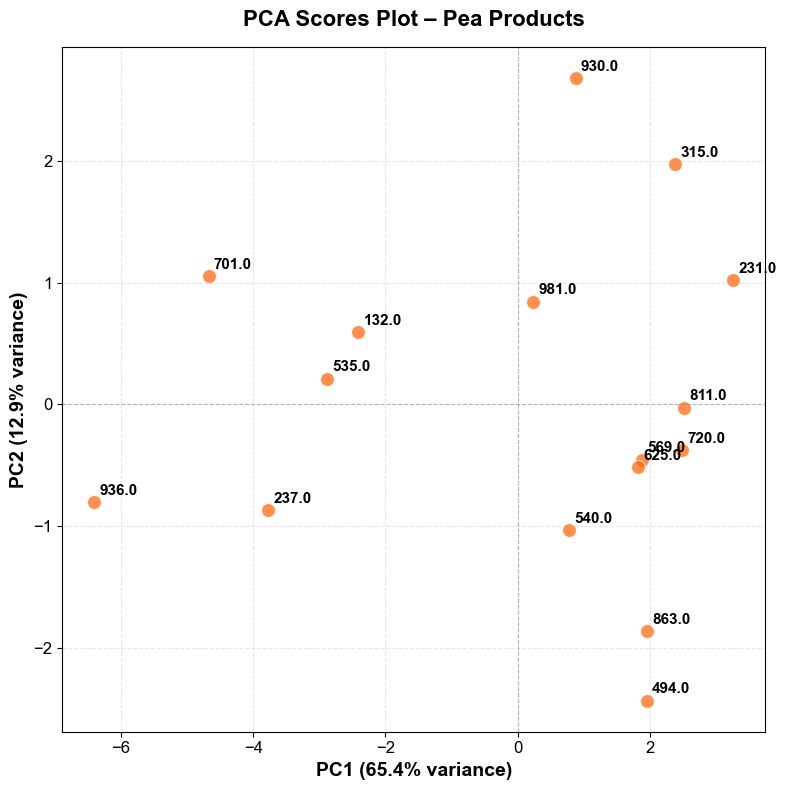

In [5]:
# Create scores plot (product map)
plt.figure(figsize=(8, 8))
sns.scatterplot(x="PC1", y="PC2", data=scores_df, s=100, color=illiniorange, alpha=0.7)

# Add product labels
for _, row in scores_df.iterrows():
    plt.text(row["PC1"] + 0.08, row["PC2"] + 0.06, 
             str(row["PRODUCT"]), 
             fontsize=11, 
             fontweight='bold',
             family='Arial',
             ha='left')

# Add reference lines at zero
plt.axhline(0, color="grey", linewidth=0.8, linestyle='--', alpha=0.5)
plt.axvline(0, color="grey", linewidth=0.8, linestyle='--', alpha=0.5)

plt.xlabel(f"PC1 ({expl_var[0]*100:.1f}% variance)", 
           fontsize=14, weight='bold', family='Arial')
plt.ylabel(f"PC2 ({expl_var[1]*100:.1f}% variance)", 
           fontsize=14, weight='bold', family='Arial')
plt.title("PCA Scores Plot – Pea Products", 
          fontsize=16, weight='bold', family='Arial', pad=15)
plt.xticks(fontsize=12, family='Arial')
plt.yticks(fontsize=12, family='Arial')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


## 6. Visualize Attribute Contributions (Loadings Plot)

A loadings plot shows which sensory attributes contribute most to each principal component. Attributes with arrows pointing in similar directions are positively correlated, while attributes pointing in opposite directions are negatively correlated.

**Interpreting the loadings plot:**
- Arrow length indicates the strength of contribution to the PCs
- Arrows pointing in the same direction = attributes that vary together
- Arrows pointing in opposite directions = attributes that vary inversely
- Attributes near the origin contribute little to these PCs

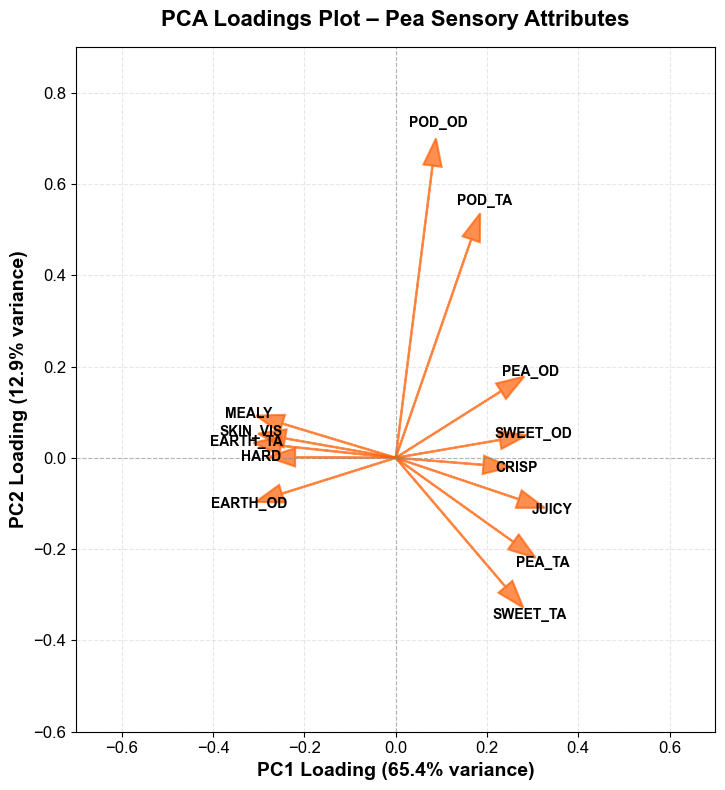

In [6]:
# Create loadings plot (attribute map)
plt.figure(figsize=(8, 8))

# Draw arrows from origin to each attribute's loading coordinates
for attr, row in loadings_df.iterrows():
    plt.arrow(0, 0, row["PC1"], row["PC2"], 
              head_width=0.04, 
              head_length=0.06, 
              fc=illiniorange, 
              ec=illiniorange, 
              length_includes_head=True,
              alpha=0.7,
              linewidth=1.5)
    # Add attribute labels
    plt.text(row["PC1"] * 1.05, row["PC2"] * 1.05, 
             attr, 
             fontsize=10, 
             ha='center', 
             va='center',
             fontweight='bold',
             family='Arial')

# Add reference lines at zero
plt.axhline(0, color="grey", linewidth=0.8, linestyle='--', alpha=0.5)
plt.axvline(0, color="grey", linewidth=0.8, linestyle='--', alpha=0.5)

# Set axis limits to accommodate all arrows
plt.xlim(-0.7, 0.7)
plt.ylim(-0.6, 0.9)

plt.xlabel(f"PC1 Loading ({expl_var[0]*100:.1f}% variance)", 
           fontsize=14, weight='bold', family='Arial')
plt.ylabel(f"PC2 Loading ({expl_var[1]*100:.1f}% variance)", 
           fontsize=14, weight='bold', family='Arial')
plt.title("PCA Loadings Plot – Pea Sensory Attributes", 
          fontsize=16, weight='bold', family='Arial', pad=15)
plt.xticks(fontsize=12, family='Arial')
plt.yticks(fontsize=12, family='Arial')
plt.gca().set_aspect('equal', 'box')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


## 7. Interpretation of Results

For the pea descriptive data, the PCA results show that the first few components capture most of the variability among products:

- **PC1**: 65.4% of total variance
- **PC2**: 12.9% of total variance
- **PC3**: 10.5% of total variance
- **PC4**: 4.6% of total variance
- **PC5**: 2.5% of total variance

**Key findings:**
- The first two components together explain **78.3%** of the total variance
- The first three components together explain **88.8%** of the total variance
- This indicates that a two- or three-dimensional PCA map provides an excellent approximation to the full 13-dimensional sensory space

**Practical implications:**
- The PC1–PC2 scores plot provides a faithful map of product similarities and differences
- Most of the systematic structure in the data can be captured in just 2-3 dimensions
- This is typical of PCA applications to structured sensory profiling data
- Products can be compared and clusters visualized with minimal loss of information

**Conclusion:**
PCA on the 13 descriptive attributes yielded a dominant first component explaining 65.4% of the total variance, with the second and third components adding 12.9% and 10.5%, respectively. The first two PCs together captured 78.3% of the overall variability in the pea sensory profiles, and the first three captured 88.8%. This indicates that a two- or three-dimensional PCA map provides an excellent approximation to the full 13-dimensional sensory space, allowing products to be compared and clusters to be visualized with minimal loss of information.
